In [80]:
import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, multivariate_normal
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import seaborn as sns
from pydiffmap import diffusion_map as dm
from sklearn.manifold import TSNE
import umap

import math

import torch
import torch.nn as nn
from mdn_model import MDNPerceptron
from convolutional_mdn_model import ConvMDNPerceptron

# specify model
## prior: $\alpha \sim Unif[-\pi,\pi],\ \ P(\lambda=0.7)=1-P(\lambda=0.1)=0.9$
## simulator: image $x$ with displacement $\lambda$, angle $a|\alpha \sim 0.5Lap(\alpha, 0.05) + 0.5Lap(\alpha, 0.0005)$

# fit convolutional MDN using PyTorch

In [129]:
with open('all_output_CMDN_2021-02-10-03-02.pkl', 'rb') as handle:
    pis, mus, sigmas = pickle.load(handle)

In [130]:
for k, pi in pis.items():
    pis[k] = pis[k].detach().numpy()

In [131]:
for k, mu in mus.items():
    mus[k] = mus[k].detach().numpy()

In [132]:
for k, sigma in sigmas.items():
    sigmas[k] = sigmas[k].detach().numpy()

In [133]:
pis

{2: array([[0.5046718 , 0.49532828],
        [0.5168594 , 0.48314056],
        [0.52316743, 0.4768326 ],
        ...,
        [0.49497628, 0.5050237 ],
        [0.4939711 , 0.5060289 ],
        [0.5282066 , 0.47179347]], dtype=float32),
 3: array([[5.2400500e-01, 4.7599214e-01, 2.8731547e-06],
        [5.1133871e-01, 1.7592553e-06, 4.8865947e-01],
        [4.8515218e-01, 5.1446629e-01, 3.8151629e-04],
        ...,
        [1.8580629e-04, 4.1050118e-01, 5.8931291e-01],
        [1.1787642e-05, 5.0447106e-01, 4.9551710e-01],
        [4.5945984e-01, 5.4053611e-01, 4.0388391e-06]], dtype=float32),
 4: array([[4.8957455e-01, 5.1042551e-01, 4.6143622e-09, 4.2037249e-09],
        [5.1882523e-01, 4.8117483e-01, 4.0420919e-10, 3.2937150e-10],
        [9.4866881e-10, 5.8445793e-10, 5.2244419e-01, 4.7755584e-01],
        ...,
        [1.6187018e-15, 8.7335407e-16, 4.7158378e-01, 5.2841628e-01],
        [4.8261752e-15, 2.6513542e-15, 4.7103930e-01, 5.2896065e-01],
        [3.0661898e-03, 2.2731835e

In [134]:
mus

{2: array([[ 1.2008368 , -1.9438733 ],
        [ 0.36087713, -2.7813213 ],
        [ 1.9021746 , -1.240123  ],
        ...,
        [ 2.4215226 , -0.718845  ],
        [ 2.560023  , -0.5809981 ],
        [ 1.6341114 , -1.509084  ]], dtype=float32),
 3: array([[-1.9436551 ,  1.2003223 ,  0.13264269],
        [-2.7559166 ,  1.494008  ,  0.37705937],
        [-1.2322912 ,  1.9122417 , -0.64821947],
        ...,
        [-1.4910759 ,  2.4351466 , -0.71792203],
        [-1.8015928 ,  2.555991  , -0.58714956],
        [-1.5072693 ,  1.6421318 , -0.34608734]], dtype=float32),
 4: array([[ 1.1951727 , -1.9482477 ,  1.380473  , -1.6053352 ],
        [ 0.384963  , -2.7623298 ,  2.3762295 , -0.65320927],
        [ 1.4899545 , -1.4831069 ,  1.9081011 , -1.2398412 ],
        ...,
        [ 1.0724992 , -1.7395484 ,  2.4328208 , -0.71507585],
        [ 0.91889364, -1.8840796 ,  2.554919  , -0.5874168 ],
        [ 1.5506896 , -1.5572302 ,  1.6394578 , -1.51092   ]],
       dtype=float32),
 5: array([[

In [135]:
sigmas

{2: array([[0.04978625, 0.04823152],
        [0.04905192, 0.04665868],
        [0.04973453, 0.04789026],
        ...,
        [0.0496684 , 0.05175523],
        [0.04674916, 0.04832349],
        [0.05129226, 0.04829455]], dtype=float32),
 3: array([[0.04882444, 0.04997731, 0.02440453],
        [0.04936678, 0.02548206, 0.04763468],
        [0.04855283, 0.05296893, 0.03404836],
        ...,
        [0.03121432, 0.04801877, 0.05090813],
        [0.02818763, 0.05163138, 0.05306155],
        [0.04880194, 0.05215967, 0.02557136]], dtype=float32),
 4: array([[0.04907281, 0.0485488 , 0.05329301, 0.06588262],
        [0.04864542, 0.047807  , 0.04213671, 0.06243033],
        [0.06180048, 0.04595415, 0.05321465, 0.04824044],
        ...,
        [0.07488818, 0.04634015, 0.04966645, 0.05188468],
        [0.07520258, 0.04616734, 0.04912759, 0.05233318],
        [0.05254276, 0.04504284, 0.05130146, 0.04928241]], dtype=float32),
 5: array([[0.04916174, 0.02231237, 0.05060147, 0.05663216, 0.05366974],


# compute KL loss

In [138]:
n_train = 7000
n_val = 3000

with open('prior_mat_20210209.pkl', 'rb') as handle:
    prior_mat = pickle.load(handle)
alphas_val = prior_mat[n_train:n_train+n_val, 0]
lambdas_val = prior_mat[n_train:n_train+n_val, 1]

In [153]:
n_test = 1000
alphas_test = prior_mat[n_train+n_val : n_train+n_val+n_test, 0]
lambdas_test = prior_mat[n_train+n_val : n_train+n_val+n_test, 1]

In [139]:
def compute_neg_log_lik(alpha, pis, mus, sigmas):
    assert(pis.shape[0] == sigmas.shape[0] == mus.shape[0])
    density = 0
    for j in range(pis.shape[0]):
        density += pis[j] * norm.pdf(x=alpha, loc=mus[j], scale=sigmas[j])
    return -np.log(density)

In [141]:
NLL_dict = {}
for k in range(2,11):
    print(k)
    all_neg_log_lik = [compute_neg_log_lik(alphas_val[i], pis[k][i], mus[k][i], sigmas[k][i]) for i in range(n_val)]

    # this is the KL loss for this model on obs data (up to additive constant)
    NLL_dict[k] = 1/n_val * sum(all_neg_log_lik)

2
3
4
5
6
7
8
9
10


In [142]:
# k=9 mixture components gives the minimum KL divergence loss
pd.Series(NLL_dict)

2    -0.729225
3    -0.884834
4    -0.914971
5    -0.906613
6    -0.897189
7    -0.917310
8    -0.905574
9    -0.910777
10   -0.905177
dtype: float64

# find min-KL distribution

In [143]:
best_k = 7  # best number of mixture components according to KL loss

In [144]:
def compute_mixture_pdf(alpha, pis, sigmas, mus):
    assert(pis.shape[0] == sigmas.shape[0] == mus.shape[0])
    density = 0
    for j in range(pis.shape[0]):
        density += pis[j] * norm.pdf(x=alpha, loc=mus[j], scale=sigmas[j])
    return density

In [271]:
with open('CMDN_test_k=7_2021-02-10-16-16.pkl', 'rb') as handle:
    test_pis, test_mus, test_sigmas = pickle.load(handle)

In [277]:
test_pis = test_pis.detach().numpy()
test_mus = test_mus.detach().numpy()
test_sigmas = test_sigmas.detach().numpy()

In [278]:
# for each observed (test) data point, calc pdf value (based on out pi, mu, sigma) of theta across a theta grid
alpha_grid = np.linspace(-4, 4, 401)
# nested list comprehension ftw
all_pdf_values_test = np.array([[compute_mixture_pdf(alpha_grid[t],
                                 test_pis[i], test_sigmas[i], test_mus[i])
                                 for t in range(len(alpha_grid))] for i in range(len(alphas_test))])

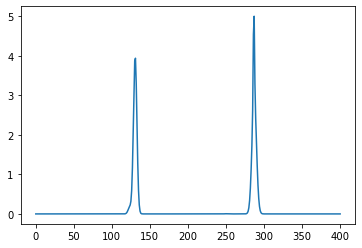

In [279]:
plt.plot(all_pdf_values_test[0])

In [280]:
den_integral = simps(all_pdf_values_test[1, :], x=alpha_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

Integral of the first density integrates to: 1.00


# compute PIT values on test data

In [281]:
# obs samples (theta,x) from joint distribution --> theta as obs posterior sample given x
pit_values = cdf_coverage(all_pdf_values_test, alpha_grid, alphas_test)

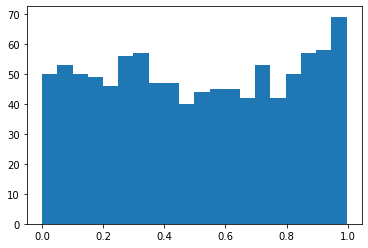

In [285]:
plt.hist(pit_values, bins=20)
plt.show()

In [286]:
pit_values_dict = {'k=7': pit_values}

In [287]:
#with open('GalSim_pit_values_dict_20210210.pkl', 'wb') as handle:
#    pickle.dump(pit_values_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [170]:
with open('galaxies_test_20210210.pkl', 'rb') as handle:
    galaxies_test = pickle.load(handle)

In [171]:
galsim_test = galaxies_test.reshape(1000, 400)

In [172]:
#np.save('GalSim_test_20210210.npy', galsim_test)

# saved $\hat r$ from MC samples, to build CIs

In [43]:
with open("GalSim_all_rhat_classifiers_2021-.pkl", 'rb') as handle:
    all_rhat_classifiers = pickle.load(handle)

C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [623]:
def get_confidence_band_range(n_trials=100, name='x1x2', alpha=0.05, points=[[1,2]]):
    sample = [1 - all_rhat_classifiers[i][name][alpha].predict_proba(points)[:, 1][0] for i in range(n_trials)]
    return [min(sample), max(sample)]

# fixed $\mathbf{x}_i$, QQ plot of $\hat r_\alpha(\mathbf{x}_i)$ vs. $\alpha$

In [290]:
lambdas_test

array([0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.1, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.1,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.1, 0.7, 0.7,
       0.7, 0.1, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.1, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.

In [36]:
points = np.array([galsim_test[0], galsim_test[-4]])

In [25]:
alphas = np.linspace(0.01, 0.99, 99)

In [292]:
rhat_alphas_xi = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_alphas_xi[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=galsim_test, y=ind_values)
        rhat_alphas_xi[name][alpha] = rhat.predict_proba(points)[:, 1]

working on classifier k=7
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99


In [616]:
confidence_qqplot = {}
confidence_qqplot['k=7'] = np.array([get_confidence_band_range(name='k=7', alpha=i, points=points) for i in alphas])

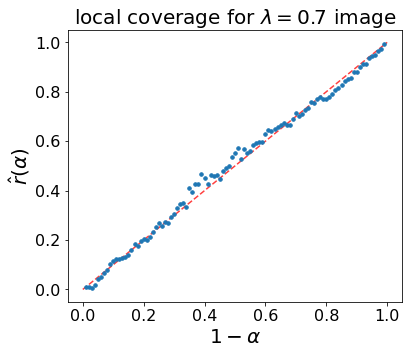

In [298]:
use_series = pd.DataFrame(rhat_alphas_xi['k=7']).T[0]

use_series.plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['k=9'].index,
                 confidence_qqplot['k=9'][:, 0],
                 confidence_qqplot['k=9'][:, 1],
                 alpha=0.15
                )
"""

plt.title("local coverage for $\lambda=0.7$ image", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

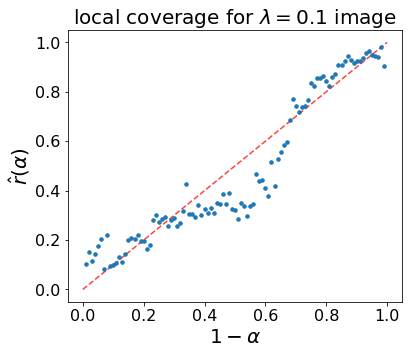

In [297]:
use_series = pd.DataFrame(rhat_alphas_xi['k=7']).T[1]

use_series.plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['k=9'].index,
                 confidence_qqplot['k=9'][:, 0],
                 confidence_qqplot['k=9'][:, 1],
                 alpha=0.15
                )
"""

plt.title("local coverage for $\lambda=0.1$ image", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [76]:
#with open('rhat_alphas_xi_20210127.pkl', 'wb') as handle:
#    pickle.dump(rhat_alphas_xi, handle, protocol=pickle.HIGHEST_PROTOCOL)

# $T_i = \frac{1}{|G|} \sum_{\alpha \in G} (\hat r_\alpha(\mathbf{x}_i) - \alpha)^2$

In [59]:
with open('GalSim_Ti_values_2021-.pkl', 'rb') as handle:
    Ti_values = pickle.load(handle)
with open('GalSim_all_rhat_alphas_2021-.pkl', 'rb') as handle:
    all_rhat_alphas = pickle.load(handle)

# global p-value based on $T_i$

In [44]:
with open("GalSim_all_unif_Ti_values_2021-.pkl", 'rb') as handle:
    all_unif_Ti_values = pickle.load(handle)

In [46]:
global_pvalues = sum([1* (pd.DataFrame(Ti_values).mean() < pd.DataFrame(all_unif_Ti_values[i]).mean())
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
global_pvalues

k=9    0.021
dtype: float64

# local p-values based on $T_i$: local CvM test

In [47]:
all_rhat_classifiers[0]['k=7']

{0.1: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 0.2: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_

In [48]:
all_rhat_classifiers[0]['k=7'][0.5].predict_proba([galsim_test[0]])

array([[0.5191299, 0.4808701]])

In [49]:
all_rhat_classifiers[0]['k=7'][0.5].predict_proba([galsim_test[-2]])

array([[0.45222516, 0.54777484]])

In [50]:
all_pvalues = sum([1* (pd.DataFrame(Ti_values) < pd.DataFrame(all_unif_Ti_values[i]))
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
all_pvalues

,k=9
0,0.202
1,0.003
2,0.124
3,0.289
4,0.225
...,...
3995,0.599
3996,0.580
3997,0.008
3998,0.169


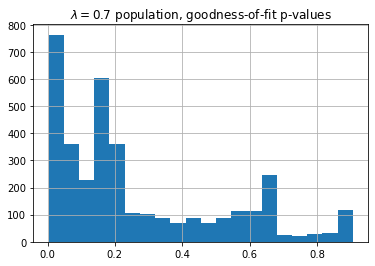

In [64]:
all_pvalues[lambdas_test == 0.7].hist(bins=20)
plt.title('$\lambda=0.7$ population, goodness-of-fit p-values')
plt.show()

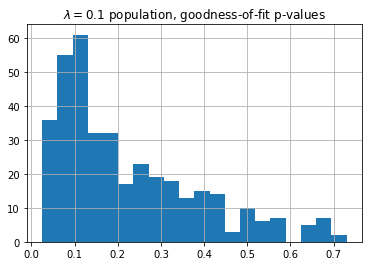

In [65]:
all_pvalues[lambdas_test == 0.1].hist(bins=20)
plt.title('$\lambda=0.1$ population, goodness-of-fit p-values')
plt.show()

# tSNE

In [263]:
tSNE_galsim_test = TSNE(n_components=2, perplexity=10).fit_transform(galsim_test)

In [328]:
#np.save('tSNE_GalSim_test_20210210.npy', tSNE_galsim_test)

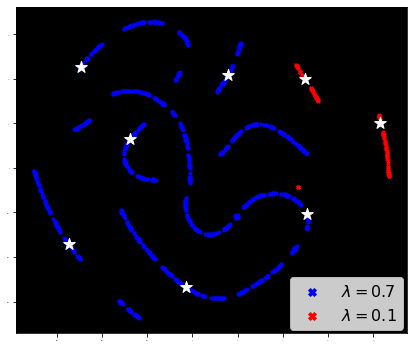

In [389]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
plt.scatter(tSNE_galsim_test[lambdas_test == 0.7][:, 0], tSNE_galsim_test[lambdas_test == 0.7][:, 1], marker='X', s=10, color='blue', label='$\lambda=0.7$')
plt.scatter(tSNE_galsim_test[lambdas_test == 0.1][:, 0], tSNE_galsim_test[lambdas_test == 0.1][:, 1], marker='X', s=10, color='red', label='$\lambda=0.1$')

ax.scatter(tSNE_galsim_test[0][0], tSNE_galsim_test[0][1], marker='*', s=150, color='white')
ax.scatter(tSNE_galsim_test[1][0], tSNE_galsim_test[1][1], marker='*', s=150, color='white')
ax.scatter(tSNE_galsim_test[3][0], tSNE_galsim_test[3][1], marker='*', s=150, color='white')
ax.scatter(tSNE_galsim_test[4][0], tSNE_galsim_test[4][1], marker='*', s=150, color='white')
ax.scatter(tSNE_galsim_test[6][0], tSNE_galsim_test[6][1], marker='*', s=150, color='white')
ax.scatter(tSNE_galsim_test[12][0], tSNE_galsim_test[12][1], marker='*', s=150, color='white')

ax.scatter(tSNE_galsim_test[-4][0], tSNE_galsim_test[-4][1], marker='*', s=150, color='white')
ax.scatter(tSNE_galsim_test[-6][0], tSNE_galsim_test[-6][1], marker='*', s=150, color='white')

#plt.title("tSNE of GalSim, perplexity=10", fontsize=18)
ax.set_facecolor('black')
lgnd = plt.legend(fontsize=16, loc=(0.7,0.01))
lgnd.legendHandles[0]._sizes = [60]
lgnd.legendHandles[1]._sizes = [60]
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

# UMAP

In [245]:
UMAP_galsim_test = umap.UMAP().fit_transform(galsim_test)

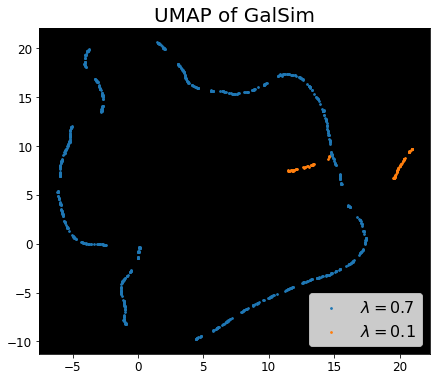

In [300]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
plt.scatter(UMAP_galsim_test[lambdas_test == 0.7][:, 0], UMAP_galsim_test[lambdas_test == 0.7][:, 1], s=3, label='$\lambda=0.7$')
plt.scatter(UMAP_galsim_test[lambdas_test == 0.1][:, 0], UMAP_galsim_test[lambdas_test == 0.1][:, 1], s=3, label='$\lambda=0.1$')
ax.set_facecolor('black')
plt.title("UMAP of GalSim", fontsize=20)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

# GalSim image examples

In [308]:
pd.DataFrame(tSNE_galsim_test).describe()

,0,1
count,1000.000000,1000.000000
mean,1.687317,-0.061766
std,38.335075,34.838779
min,-70.052795,-67.399597
25%,-26.909513,-26.951133
50%,-2.270750,0.653653
75%,28.565495,24.037873
max,87.107483,65.835594


In [309]:
tSNE_galsim_test[0]

array([-54.777447, -34.164948], dtype=float32)

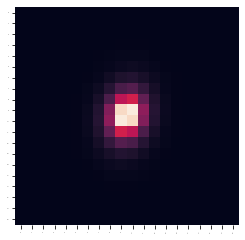

In [384]:
plt.figure(figsize=(4,4))
sns.heatmap(galsim_test[0].reshape(20,20), cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [314]:
tSNE_galsim_test[1]

array([ -2.864285, -53.49797 ], dtype=float32)

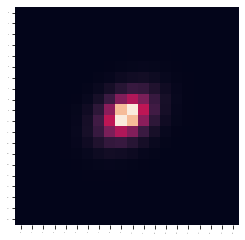

In [359]:
plt.figure(figsize=(4,4))
sns.heatmap(galsim_test[1].reshape(20,20), cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [317]:
tSNE_galsim_test[3]

array([-49.476234,  45.2959  ], dtype=float32)

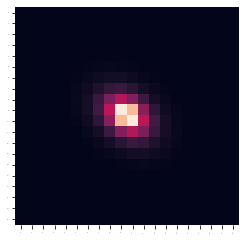

In [360]:
plt.figure(figsize=(4,4))
sns.heatmap(galsim_test[3].reshape(20,20), cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [320]:
tSNE_galsim_test[4]

array([15.717474, 41.818348], dtype=float32)

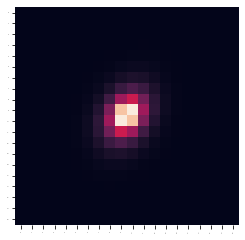

In [361]:
plt.figure(figsize=(4,4))
sns.heatmap(galsim_test[4].reshape(20,20), cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [324]:
tSNE_galsim_test[6]

array([ 50.735954, -20.74863 ], dtype=float32)

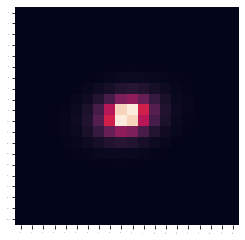

In [362]:
plt.figure(figsize=(4,4))
sns.heatmap(galsim_test[6].reshape(20,20), cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [348]:
tSNE_galsim_test[12]

array([-27.589544,  13.05133 ], dtype=float32)

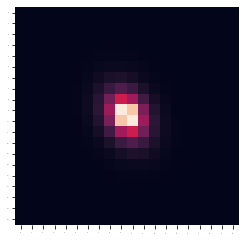

In [363]:
plt.figure(figsize=(4,4))
sns.heatmap(galsim_test[12].reshape(20,20), cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [332]:
tSNE_galsim_test[-4]

array([83.12487 , 20.087643], dtype=float32)

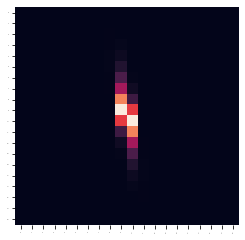

In [364]:
plt.figure(figsize=(4,4))
sns.heatmap(galsim_test[-4].reshape(20,20), cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [337]:
tSNE_galsim_test[-6]

array([49.821854, 40.051247], dtype=float32)

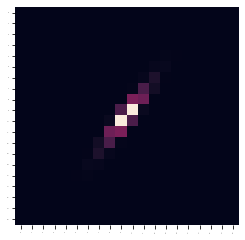

In [365]:
plt.figure(figsize=(4,4))
sns.heatmap(galsim_test[-6].reshape(20,20), cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()